## Imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, f1_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Parameter

## Parameters

In [24]:
BATCH_SIZE = 64
NUM_CLASSES = 3
INPUT_DIM = 28 * 6  # Flattened dimension (T*F)
OUTPUT_DIM = NUM_CLASSES
KL_WEIGHT = 1e-6
T = 30

PRIORS = {
    'prior_mu': -0.5,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}

SITE = 'A'
YEAR = 2020


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [6]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(X.shape, y.shape)

(2249845, 28, 6) (2249845,)


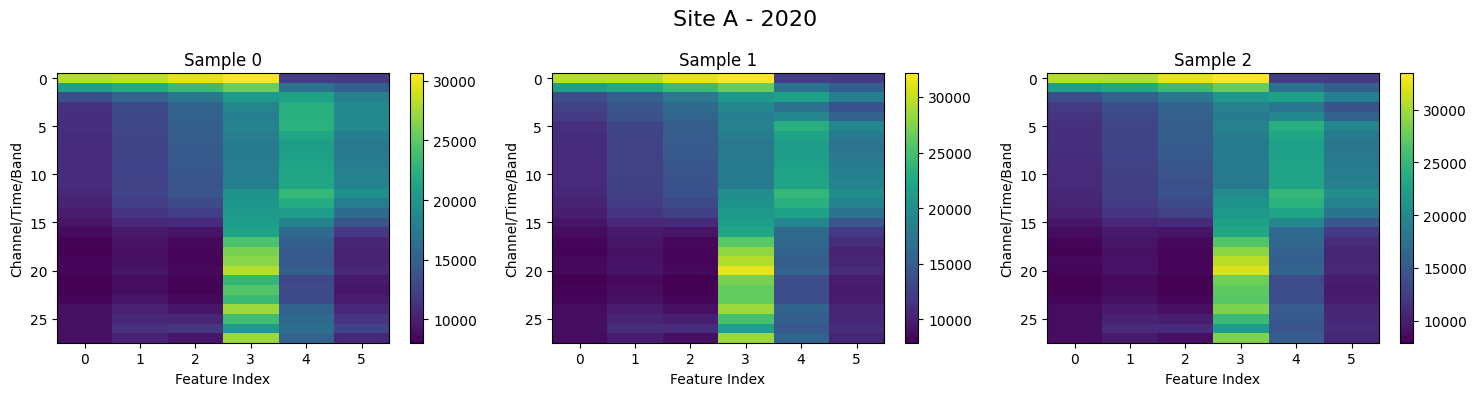

In [7]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site A - 2020 =======
Feature 0: Mean = 9234.2181, Std = 1619.8221
Feature 1: Mean = 10326.2330, Std = 1694.5932
Feature 2: Mean = 10523.3406, Std = 2207.3945
Feature 3: Mean = 18191.7934, Std = 4121.2513
Feature 4: Mean = 15938.4485, Std = 2887.7106
Feature 5: Mean = 13173.9971, Std = 3119.2401

Global Mean: 12898.0051
Global Std Dev: 4251.3203


## Pre-processing the Input

In [9]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

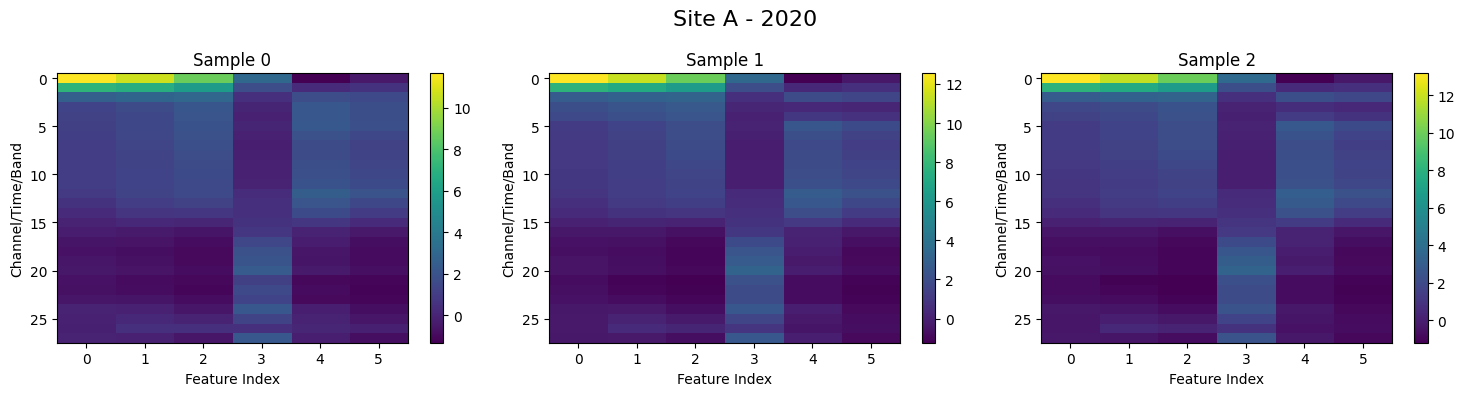

In [10]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site A - 2020 =======
Feature 0: Mean = -0.0006, Std = 0.8760
Feature 1: Mean = -0.0002, Std = 0.8654
Feature 2: Mean = 0.0012, Std = 0.8446
Feature 3: Mean = -0.0000, Std = 0.9025
Feature 4: Mean = 0.0000, Std = 0.8675
Feature 5: Mean = -0.0000, Std = 0.8547

Global Mean: 0.0000
Global Std Dev: 1.0000


## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         368245    16.37%
1         1253893   55.73%
2         627707    27.90%

Total samples: 2249845


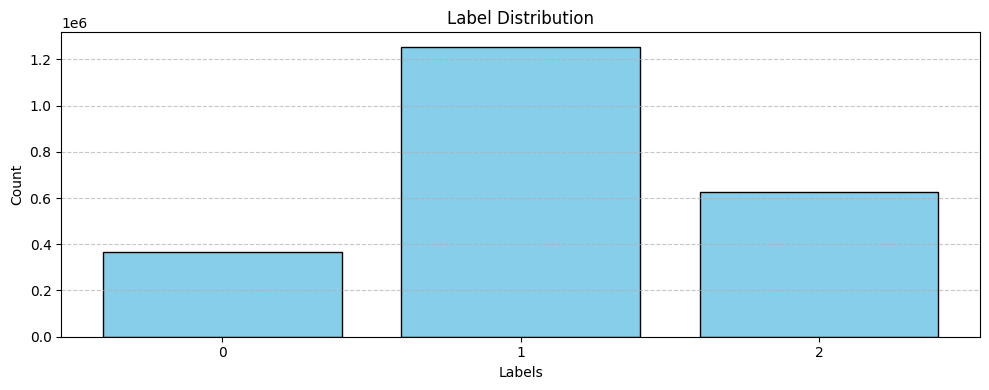

In [12]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [16]:
class FlattenedDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X: torch.Tensor of shape (N, T, F)
            y: torch.Tensor of shape (N,)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Flatten the (T, F) into (T*F)
        x_flat = self.X[idx].reshape(-1)
        return x_flat, self.y[idx]

In [17]:
full_dataset = FlattenedDataset(X, y)
full_dataloader = DataLoader(full_dataset, batch_size=BATCH_SIZE)

## Loading the Model

In [20]:
class ModuleWrapper(nn.Module):
    """Wrapper for nn.Module with support for sample & n_samples propagation"""
    def __init__(self):
        super(ModuleWrapper, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x, sample=True, n_samples=1):
        # x can be (batch, features) or (n_samples, batch, features)
        for module in self.children():
            name = module._get_name()
            # If module is a BBB layer, pass sample & n_samples
            if 'BBB' in name:
                x = module(x, sample=sample, n_samples=n_samples)
            else:
                # Non-BBB modules (activations, etc.)
                # If x has samples dim, merge before applying, then unmerge
                if x.dim() == 3:
                    n, b, f = x.shape
                    x = x.reshape(n * b, f)        # <-- changed .view -> .reshape
                    x = module(x)
                    # If module changes feature size, recompute new feature dim
                    new_f = x.shape[1]
                    x = x.reshape(n, b, new_f)    # <-- changed .view -> .reshape
                else:
                    x = module(x)
        # compute kl from all modules that have kl_loss (independent of n_samples)
        kl = torch.tensor(0.0, device=x.device)
        for module in self.modules():
            if hasattr(module, 'kl_loss') and module is not self:
                kl = kl + module.kl_loss()
        return x, kl

In [21]:
class BBBLinear(ModuleWrapper):
    def __init__(self, in_features, out_features, bias=True, priors=None, device='cpu'):
        super(BBBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias
        self.device = device

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu  = Parameter(torch.empty((out_features, in_features), device=self.device))
        self.W_rho = Parameter(torch.empty((out_features, in_features), device=self.device))

        if self.use_bias:
            self.bias_mu  = Parameter(torch.empty((out_features), device=self.device))
            self.bias_rho = Parameter(torch.empty((out_features), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)
        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def _compute_sigma(self):
        # stable softplus
        W_sigma = torch.log1p(torch.exp(self.W_rho))
        if self.use_bias:
            bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        else:
            bias_sigma = None
        return W_sigma, bias_sigma

    def forward(self, input, sample=True, n_samples=1):
        """
        input: (batch, in_features)  OR  (n_samples, batch, in_features)
        returns:
            if n_samples>1: outputs (n_samples, batch, out_features)
            else: outputs (batch, out_features)
        """
        W_sigma, bias_sigma = self._compute_sigma()
        self.W_sigma = W_sigma            # keep attributes for kl_loss
        if self.use_bias:
            self.bias_sigma = bias_sigma

        # Case A: sample=True and n_samples>1 -> vectorized multiple draws
        if sample and n_samples > 1:
            if input.dim() == 2:
                batch_in = input.unsqueeze(0).expand(n_samples, input.size(0), input.size(1))  # (n, b, i)
            else:
                # input already shaped (n_input, b, i)
                batch_in = input
                if batch_in.shape[0] != n_samples:
                    batch_in = batch_in[0].unsqueeze(0).expand(n_samples, *batch_in.shape[1:])

            # sample weights for all n at once
            W_eps = torch.randn((n_samples, *self.W_mu.size()), device=self.device)  # (n, out, in)
            weights = self.W_mu.unsqueeze(0) + W_sigma.unsqueeze(0) * W_eps             # (n, out, in)

            # batch_in: (n, b, in); weights: (n, out, in)
            outputs = torch.einsum('noi,nbi->nbo', weights, batch_in)

            if self.use_bias:
                bias_eps = torch.randn((n_samples, *self.bias_mu.size()), device=self.device)  # (n, out)
                biases = self.bias_mu.unsqueeze(0) + bias_sigma.unsqueeze(0) * bias_eps       # (n, out)
                outputs = outputs + biases.unsqueeze(1)  # (n, b, out)
            return outputs

        # Case B: sample=True and n_samples == 1 -> single stochastic draw
        if sample and n_samples == 1:
            W_eps = torch.randn(self.W_mu.size(), device=self.device)
            weight = self.W_mu + W_eps * W_sigma
            if self.use_bias:
                bias_eps = torch.randn(self.bias_mu.size(), device=self.device)
                bias = self.bias_mu + bias_eps * bias_sigma
            else:
                bias = None
            # input must be (batch, in) or (n, b, f)
            if input.dim() == 3:
                n, b, f = input.shape
                flat = input.reshape(n * b, f)                # <-- reshape
                out_flat = F.linear(flat, weight, bias)
                out = out_flat.reshape(n, b, -1)              # <-- reshape
                return out
            else:
                return F.linear(input, weight, bias)

        # Case C: deterministic (use mu)
        weight = self.W_mu
        if self.use_bias:
            bias = self.bias_mu
        else:
            bias = None
        if input.dim() == 3:
            n, b, f = input.shape
            flat = input.reshape(n * b, f)                    # <-- reshape
            out_flat = F.linear(flat, weight, bias)
            out = out_flat.reshape(n, b, -1)                  # <-- reshape
            return out
        else:
            return F.linear(input, weight, bias)

    def kl_loss(self):
        # ensure W_sigma and bias_sigma exist
        if not hasattr(self, 'W_sigma'):
            self.W_sigma, _ = self._compute_sigma()
        kl = KL_DIV(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            if not hasattr(self, 'bias_sigma'):
                _, self.bias_sigma = self._compute_sigma()
            kl += KL_DIV(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl


def KL_DIV(mu_q, sig_q, mu_p, sig_p):
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    return kl

In [22]:
class BBBMLP(ModuleWrapper):
    '''The architecture of LeNet with Bayesian Layers'''

    def __init__(self, inputs, outputs, priors, device=DEVICE):
        super(BBBMLP, self).__init__()

        self.num_classes = outputs
        self.priors = priors
        self.act = nn.ReLU

        self.fc0 = BBBLinear(inputs, 256, bias=True, priors=self.priors, device=device)
        self.act0 = self.act()

        self.fc1 = BBBLinear(256, 128, bias=True, priors=self.priors, device=device)
        self.act1 = self.act()

        self.fc2 = BBBLinear(128, 64, bias=True, priors=self.priors, device=device)
        self.act2 = self.act()

        self.fc3 = BBBLinear(64, 32, bias=True, priors=self.priors, device=device)
        self.act3 = self.act()

        self.fc4 = BBBLinear(32, outputs, bias=True, priors=self.priors, device=device)

In [27]:
model = BBBMLP(inputs=INPUT_DIM, outputs=OUTPUT_DIM, priors=PRIORS).to(DEVICE)
print(model)

BBBMLP(
  (fc0): BBBLinear()
  (act0): ReLU()
  (fc1): BBBLinear()
  (act1): ReLU()
  (fc2): BBBLinear()
  (act2): ReLU()
  (fc3): BBBLinear()
  (act3): ReLU()
  (fc4): BBBLinear()
)


In [28]:
checkpoint = torch.load("/kaggle/input/bmlp/pytorch/default/1/BMLP.pth", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Evaluaion Metrics

In [29]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C)
    returns average of accuracies across T (scalar)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)                # (T, B)
        eq = (preds == labels.unsqueeze(0))          # (T, B)
        accs = eq.float().mean(dim=1)                # (T,)
        return accs.mean().item()
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

def compute_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

## Testing the Model

In [30]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score

def validate(model, dataloader, T, device):
    model.eval()
    all_preds = []
    all_labels = []

    total_acc = 0.0

    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # (T, B, C) stochastic outputs
            outputs, _ = model(x_batch, sample=True, n_samples=T)

            # ---- Accuracy (avg of per-sample accuracies) ----
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # ---- Averaging in probability space for final preds ----
            probs = torch.softmax(outputs, dim=2)           # (T, B, C)
            probs_mean = probs.mean(dim=0)                  # (B, C)
            preds_mean = torch.argmax(probs_mean, dim=1)    # (B,)

            all_preds.append(preds_mean.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Cohen's Kappa
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())

    # Per-class F1
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)

    # Macro-average F1
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")

    # Accuracy over whole dataset
    acc = total_acc / len(dataloader.dataset)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Stochastic Accuracy (mean over T): {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Per-class F1: {per_class_f1}")
    print(f"Average F1 (macro): {avg_f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
    plt.tight_layout()
    plt.show()

    return acc, kappa, per_class_f1, avg_f1

Stochastic Validation (T=30): 100%|██████████| 35154/35154 [02:46<00:00, 211.10it/s]


Stochastic Accuracy (mean over T): 0.8145
Cohen's Kappa: 0.6658
Per-class F1: [0.87958992 0.86472801 0.61832175]
Average F1 (macro): 0.7875


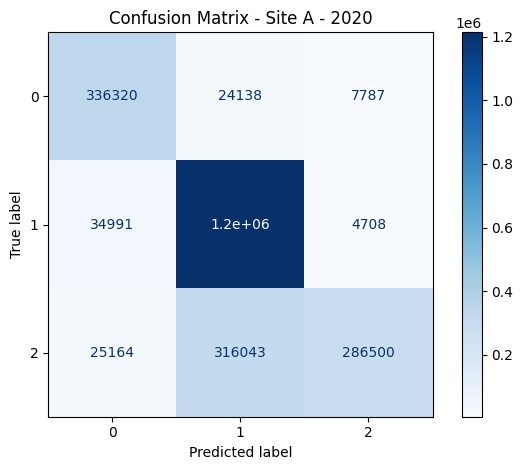

In [31]:
acc, kappa, per_class_f1, avg_f1 = validate(model, full_dataloader, T=30, device=DEVICE)

<hr>